# Deep Learning Experiments
If you would like here is some structure for your experiments in a jupyter notebook. Here are some important keyboard shortcuts 
* shift + enter - run current cell and move to next cell
* ctrl + enter - run current cell 

## Dependencies

In [91]:
# if you need any other modules feel free to add them here
import sys
sys.path.append("..") 

# from src.models import Digit_Classifier, Dog_Classifier_FC, Dog_Classifier_Conv, Synth_Classifier
# from src.run_model import run_model
from data.load_data import load_mnist_data
from data.my_dataset import MyDataset
from dogs import *

import matplotlib.pyplot as plt
import numpy as np
import time
import csv
import os

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [86]:
def train_model(model, criterion, optimizer, trainloader, epochs=10, devloader=None, print_info=True):
    epochs_loss = []
    epoch_acc = []
    running_loss = 0.0
    # the length of the train loader will give you the number of mini-batches
    # not the cleanest solution but for now it generalizes well and avoids 
    # computation that we don't need
    minibatches = len(trainloader)
    # moving the network onto the gpu/cpu
    model = model.to(device)
    for epoch in range(epochs):
        epoch_loss = 0.0
#         batches_complete = 0
        for batch, labels in trainloader: # Per this doc, (batch,labels) = trainloader.__getitem__(); https://pytorch.org/docs/stable/torchvision/datasets.html#cifar

            # Keeping track of number of batches processed
#             if batches_complete % 1000 == 0:
#                 print("BATCHES COMPLETE: ", batches_complete)
#             batches_complete += 1
            
            # batch is a tensor with m elements, where each element is 
            # a training example

            # moving batch/labels onto the gpu/cpu
            batch, labels = batch.to(device), labels.to(device)
            
            # zeroing the parameters of the model 
            # becuase we want to optimize them
            optimizer.zero_grad()
            
            # forward pass
            # getting the predictions from our model by passing in a mini-batch
            # the ouput will have shape (mini-batch-size, number-of-classes)
            # where each element of output is the probabliity of that example being
            # the classification correspoding to the index of the value
            output = model(batch.float()) # <---- Added .float() as a modification to avoid Runtime error per this post: https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
            loss = criterion(output, labels.long()) # <---- Added .long() per a CampusWire discussion in post #2505
            
            # backward pass
            loss.backward()
            
            # optimize the parameters
            optimizer.step()
            
            # add the loss of a mini-batch to the list of epoch loss
            epoch_loss += loss.item()

        #  after each epoch we need to average out the loss across all minibatches
        epochs_loss.append(epoch_loss/minibatches)
        # printing some info
        if print_info:
            print(f'Epoch: {epoch} Loss: {epoch_loss/minibatches}')
    return model, epoch_loss
                

def test_model(model, testloader): # Takes in just model you want to test and the data you want to test it on
    # variables to keep count of correct labels and the total labels in a mini batch
    correct = 0
    total = 0
    # since we're testing the model we don't need to perform backprop
    with torch.no_grad(): # Disables gradient calculation to save memory; we're sure we won't be using Tensor.backward()
        for batch, labels in testloader:
            batch, labels = batch, labels # So we don't modify original dataset?
            output = model(batch.float()) # <---- Added .float() to solve for RuntimeError
            # this gives us the index with the highest value outputed from the last layer
            # which coressponds to the most probable label/classification for an image
            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy
    
device = torch.device('cuda' if torch.cuda.is_available()  else 'cpu')
print('Using device: ', device)

Using device:  cpu


## MNIST

#### Cell for Spliting Data
Here I have given you an example of loading in a training dataset. Remember you need 4 differently sized datasets for this part of the experiment (experimenting trainingset size to see how it changes accuracy and training time). I have also given you the testing set you need, you won't need to make any other testing sets. 

### Ok, I will play around with the load_mnist_data function a bit, to get an idea of how it works (I also read the code)

In [6]:
training_size = 50 # this corresponds to examples_per_class parameter

In [8]:
example_data_split = load_mnist_data(10, 1.0, training_size)

In [11]:
example_data_split

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([], shape=(1, 0), dtype=float64),
 array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
        9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
        6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9,
        0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2,
        9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4,
        5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9,
        9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5,
        9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8,
        3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 

In [10]:
len(example_data_split)

4

In [13]:
example_data_split[0].shape # The first element is the training features, which has 500 flattened images

(500, 784)

In [15]:
example_data_split[1].shape # The second element is the testing features; Here it is empty because we specified fraction = 1

(1, 0)

In [19]:
example_data_split[2].shape # These are the training targets i.e. the labels, the actual numbers in the images

(500,)

In [17]:
np.unique(example_data_split[2], return_counts=True) # Confirmed that there are indeed 50 of each class in our training dataset

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))

In [20]:
example_data_split[3].shape # These are the testing targets, which is empty because fraction = 1

(0,)

In [21]:
example_training_set = MyDataset(example_data_split[0], example_data_split[2])

In [26]:
print(example_training_set.x.shape) # The MyDataset class is just a wrapper that allows us to iterate over the data, because it gives it the __getitem__() method
print(len(example_training_set)) # The len method is also nicely defined, which allows us to see the number of observations, just like a PyTorch Dataset

(500, 784)
500


### I think I understand how load_mnist_data works now; Let's create the 4 training datasets of 4 different sizes

In [31]:
train_datasets = dict()

for size in [500,1000,1500, 2000]:
    example_data_split = load_mnist_data(10, 1.0, size/10)
    example_training_set = MyDataset(example_data_split[0], example_data_split[2])
    train_datasets[size] = example_training_set

In [37]:
# Let's double-check that all our training datasets are balanced
for key, value in train_datasets.items():
    print(np.unique(value.y, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([50, 50, 50, 50, 50, 50, 50, 50, 50, 50]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([150, 150, 150, 150, 150, 150, 150, 150, 150, 150]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8), array([200, 200, 200, 200, 200, 200, 200, 200, 200, 200]))


### I will need to convert these MyDataset objects to DataLoader objects

In [41]:
train_loaders = dict()

for key, value in train_datasets.items():
    
    train_loaders[key] = torch.utils.data.DataLoader(value,
                                                     batch_size=4,
                                                     shuffle=True,
                                                     num_workers=2)

In [42]:
train_loaders

{500: <torch.utils.data.dataloader.DataLoader at 0x7fc0403577c0>,
 1000: <torch.utils.data.dataloader.DataLoader at 0x7fc0403572b0>,
 1500: <torch.utils.data.dataloader.DataLoader at 0x7fc040860400>,
 2000: <torch.utils.data.dataloader.DataLoader at 0x7fc0401737f0>}

In [54]:
# I created the training sets above; below I create the testing dataset per the instructions originally in this notebook
# testing set
data_split = load_mnist_data(10, 0, 100) # I'm a bit confused as to why we call load_mnist_data twice; 
                                          # it is capable of giving us train & test data at the same time; 
                                          # aren't we duplicating observations across train and test set this way?
                                          # Maybe it's to ensure we all have the same test dataset :shrug
testing_set = MyDataset(data_split[1], data_split[3])

# And then the test DataLoader
test_loader = torch.utils.data.DataLoader(testing_set
                                          , batch_size=4
                                          , shuffle=False # I think for the test dataset I don't need shuffle=True
                                          , num_workers=2) 

In [55]:
np.unique(data_split[3], return_counts=True) # We get 100 samples each when taking size 100;;;When using size=1000, We don't have the full 1000 observations for each class

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))

#### Cell for Training
Here you need to train 4 models with training set sizes [500, 1000, 1500, 2000]. Track the training time & accuracy. 

***Optinal*** 

you can track your training time and accuracy by making a dictionary entry for the model ex.
```training_time.update({model_size:training_time})```

I've included the dictionary defintions in a cell below, if this method is confusing to you feel free to track any other way.


### First, let's define the model architecture

In [87]:
class mnistNet(nn.Module):
    def __init__(self):
        super(mnistNet, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         x = F.log_softmax(x, dim=1) # According to the documentation, I don't need to add log_softmax, because it is integrated in the CrossEntropyLoss class
        return x

In [88]:
# loss_function = nn.CrossEntropyLoss()
# solver = optim.SGD(params=mnist_net.parameters() ,lr=0.01)

In [74]:
# Dicionaries to track metrics
# training time
training_time = {}
# training loss
training_loss = {}
# training accurary 
training_acc = {}
# testing loss 
# OPTIONAL
testing_loss = {}
# testing acc
testing_acc = {}


In [89]:

for size, train_loader in train_loaders.items():
    
    start = time.time()

    mnist_net = mnistNet()
    mnist_net = mnist_net.float()
    
    loss_function = nn.CrossEntropyLoss()
    solver = optim.SGD(params=mnist_net.parameters() ,lr=0.01)

    trained_model, epochs_loss = train_model(model=mnist_net
                                             , criterion = loss_function
                                             , optimizer = solver
                                             , trainloader = train_loader
                                             , epochs = 100
                                             , print_info=True)
    
    end = time.time()
    
    test_accuracy = test_model(trained_model, test_loader) 
    
    training_time[size] = end-start
    training_loss[size] = epochs_loss
    testing_acc[size] = test_accuracy

Epoch: 0 Loss: 2.283967016220093
Epoch: 1 Loss: 2.2172321701049804
Epoch: 2 Loss: 2.086350992202759
Epoch: 3 Loss: 1.8550745906829833
Epoch: 4 Loss: 1.5177337474822998
Epoch: 5 Loss: 1.1533058831691743
Epoch: 6 Loss: 0.8721833817958832
Epoch: 7 Loss: 0.6901570477485657
Epoch: 8 Loss: 0.5782067333459854
Epoch: 9 Loss: 0.49208107936382295
Epoch: 10 Loss: 0.4252114279270172
Epoch: 11 Loss: 0.3721803024709225
Epoch: 12 Loss: 0.32242185561358927
Epoch: 13 Loss: 0.29014152847975494
Epoch: 14 Loss: 0.2551022754535079
Epoch: 15 Loss: 0.22535398706793786
Epoch: 16 Loss: 0.1990913347899914
Epoch: 17 Loss: 0.1776972509175539
Epoch: 18 Loss: 0.15726644360274075
Epoch: 19 Loss: 0.1383003909289837
Epoch: 20 Loss: 0.1243285821005702
Epoch: 21 Loss: 0.1129237575829029
Epoch: 22 Loss: 0.09889189088717103
Epoch: 23 Loss: 0.08795044277608395
Epoch: 24 Loss: 0.0805586624443531
Epoch: 25 Loss: 0.07090350460633635
Epoch: 26 Loss: 0.06554334210325033
Epoch: 27 Loss: 0.06127654662542045
Epoch: 28 Loss: 0.0551

### Note: Training locally on CPU took forever! So, I used Google Colab; will save the notebook as colab.ipynb

In [5]:
# HINT: To get the current time use: 
#     current_time = time.time()

### Graphs

#### Style
matplotlib has a lot of different styles which can be found here: 
https://matplotlib.org/3.2.2/gallery/style_sheets/style_sheets_reference.html

In [24]:
from matplotlib import style
style.use('fivethirtyeight')

#### Model Size vs Training Time

Text(0, 0.5, 'Time (seconds)')

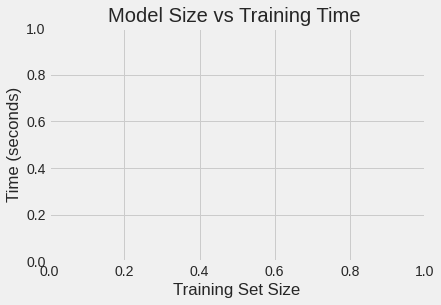

In [25]:
plt.title("Model Size vs Training Time ")
plt.xlabel('Training Set Size')
plt.ylabel('Time (seconds)')

#### Model size Vs Accuracy

Text(0, 0.5, 'Accuracy')

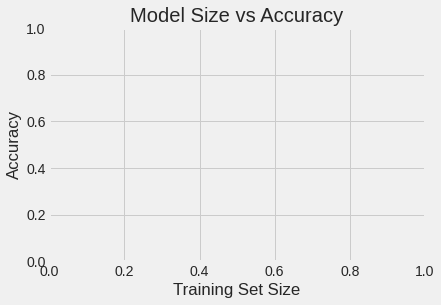

In [26]:
plt.title("Model Size vs Accuracy")
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')

#### OPTIONAL Training loss

Text(0.5, 0, 'Epoch')

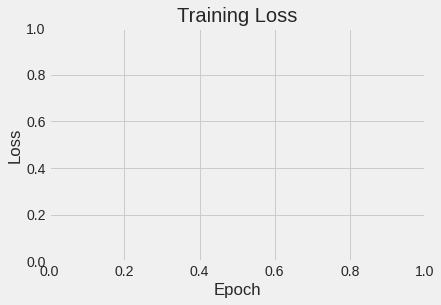

In [27]:
plt.legend(['500', '1000', '1500', '2000'], loc='upper right')
plt.title('Training Loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')

## Exploring DogSet

#### Dogset CSV 
Explore breeds and trainingset vs testingset size using the included csv for DogSet

In [92]:
base_folder = '../data'
sub_folder = 'DogSet'
dataset_name = 'dogs.csv'
data_path = os.path.join(base_folder, sub_folder, dataset_name)

sizes = {'train':0, 'test':0, 'valid':0}
breeds = []

## Training a model on DogSet

#### Load the Data

In [96]:
dogs_dataset = DogsDataset(os.path.join('data', sub_folder))

loading train...
loading valid...
loading test...


In [99]:
train_dogs_features, train_dogs_targets = dogs_dataset.get_train_examples()

In [105]:
train_dogs_features.shape # `[num_examples, height, width, n_channels]`

(7665, 64, 64, 3)

In [104]:
train_dogs_targets.shape

(7665,)

In [109]:
np.unique(train_dogs_targets, return_counts=True) # There are 10 breeds, roughly balanced

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([740, 778, 788, 786, 742, 775, 772, 766, 738, 780]))

### Validation data

In [111]:
valid_dogs_features, valid_dogs_targets = dogs_dataset.get_validation_examples()

In [112]:
valid_dogs_features.shape # `[num_examples, height, width, n_channels]`

(2000, 64, 64, 3)

In [113]:
valid_dogs_targets.shape

(2000,)

In [114]:
np.unique(valid_dogs_targets, return_counts=True) # There are 10 breeds, roughly balanced

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([222, 195, 194, 197, 207, 188, 202, 202, 205, 188]))

### Test Data

In [115]:
test_dogs_features, test_dogs_targets = dogs_dataset.get_test_examples()

In [116]:
test_dogs_features.shape # `[num_examples, height, width, n_channels]`

(555, 64, 64, 3)

In [117]:
test_dogs_targets.shape

(555,)

In [118]:
np.unique(test_dogs_targets, return_counts=True) # There are 10 breeds, roughly balanced

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([60, 59, 53, 48, 46, 55, 50, 60, 66, 58]))

In [123]:
# Converting to datasets
train_dog_set = MyDataset(train_dogs_features, train_dogs_targets)
valid_dog_set = MyDataset(valid_dogs_features, valid_dogs_targets)
test_dog_set = MyDataset(test_dogs_features, test_dogs_targets)

In [203]:
# Converting to dataloaders

train_dogs_loader = torch.utils.data.DataLoader(train_dog_set
                                                , batch_size=10
                                                , shuffle=True # I think for the test dataset I don't need shuffle=True
                                                , num_workers=2) 

valid_dogs_loader = torch.utils.data.DataLoader(valid_dog_set
                                                , batch_size=10
                                                , shuffle=True # I think for the test dataset I don't need shuffle=True
                                                , num_workers=2) 

test_dogs_loader = torch.utils.data.DataLoader(test_dog_set
                                                , batch_size=10
                                                , shuffle=True # I think for the test dataset I don't need shuffle=True
                                                , num_workers=2) 

### Checking the breed types

In [137]:
for idx in range(10):
    print("INDEX: ", idx, " ", "BREED: ", dogs_dataset.get_semantic_label(idx))

INDEX:  0   BREED:  samoyed
INDEX:  1   BREED:  miniature_poodle
INDEX:  2   BREED:  golden_retriever
INDEX:  3   BREED:  great_dane
INDEX:  4   BREED:  dalmatian
INDEX:  5   BREED:  collie
INDEX:  6   BREED:  siberian_husky
INDEX:  7   BREED:  yorkshire_terrier
INDEX:  8   BREED:  chihuahua
INDEX:  9   BREED:  saint_bernard


In [189]:
# Taking a few examples of the samoyed 
dogs_examples = dogs_dataset.get_examples_by_label('train', 0, num_examples = 20); 
print(dogs_examples.shape)

tensor_dogs_examples = torch.tensor(dogs_examples); 
print(tensor_dogs_examples.shape)

(20, 64, 64, 3)
torch.Size([20, 64, 64, 3])


### The breed I'm working with is samoyed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


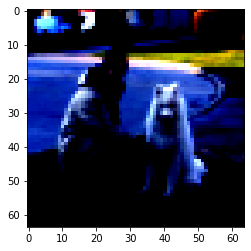

In [202]:
plt.imshow(np.transpose(tensor_dogs_examples[13], (0, 1, 2) )) # 
plt.show()

#### Train the Model

In [205]:
class dogNet(nn.Module):
    def __init__(self):
        super(dogNet, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 64 * 64 * 3) # Flattens
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Question 7 - How many connections (weights) does this network have?

In [209]:
n_first_layer = 64 * 64 * 3 * 128 # 64*64*3 are the number of inputs from a single image and 128 is the size of the first hidden layer
n_second_layer = 128 * 64 # each node in first hidden layer is connected to each node in second hidden layer
n_third_layer = 64 * 10 # second hidden layer nodes connected to each output node (10 such, 1 for each breed)
print("TOTAL NUMBER OF WEIGHTS = ", n_first_layer+n_second_layer+n_third_layer )

TOTAL NUMBER OF WEIGHTS =  1581696


In [229]:
def dogs_train_model(model, criterion, optimizer, trainloader, validloader, epochs=10, devloader=None, print_info=True):
    epochs_train_loss = []
    epochs_valid_loss = []
    
    epochs_train_acc = []
    epochs_valid_acc = []
    
    running_loss = 0.0
    # the length of the train loader will give you the number of mini-batches
    # not the cleanest solution but for now it generalizes well and avoids 
    # computation that we don't need
    minibatches = len(trainloader)
    valid_minibatches = len(validloader)
    # moving the network onto the gpu/cpu
    model = model.to(device)
    for epoch in range(epochs):
        
        epoch_train_loss = 0.0  
#         batches_complete = 0
        for batch, labels in trainloader: # Per this doc, (batch,labels) = trainloader.__getitem__(); https://pytorch.org/docs/stable/torchvision/datasets.html#cifar
            
            # batch is a tensor with m elements, where each element is 
            # a training example

            # moving batch/labels onto the gpu/cpu
            batch, labels = batch.to(device), labels.to(device)
            
            # zeroing the parameters of the model 
            # becuase we want to optimize them
            optimizer.zero_grad()
            
            # forward pass
            # getting the predictions from our model by passing in a mini-batch
            # the ouput will have shape (mini-batch-size, number-of-classes)
            # where each element of output is the probabliity of that example being
            # the classification correspoding to the index of the value
            output = model(batch.float()) # <---- Added .float() as a modification to avoid Runtime error per this post: https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ
            loss = criterion(output, labels.long()) # <---- Added .long() per a CampusWire discussion in post #2505
            
            # backward pass
            loss.backward()
            
            # optimize the parameters
            optimizer.step()
            
            # add the loss of a mini-batch to the list of epoch loss
            epoch_train_loss += loss.item()

        # TRAINING METRICS
        #  after each epoch we need to average out the loss across all minibatches
        epochs_train_loss.append(epoch_train_loss/minibatches)
        # printing some info
        if print_info:
            print(f'Epoch: {epoch} Training Loss: {epoch_train_loss/minibatches}')
            
        train_acc = test_model(model, trainloader)
        epochs_train_acc.append(train_acc)
        if print_info:
            print(f'Epoch: {epoch} Training Accuracy: {train_acc}')
        # VALIDATION METRICS
        with torch.no_grad(): # Disables gradient calculation to save memory; we're sure we won't be using Tensor.backward()
            # variables to keep count of correct labels and the total labels in a mini batch
            correct = 0
            total = 0
            epoch_valid_loss = 0.0  
            for batch, labels in validloader:
                
                batch, labels = batch, labels # So we don't modify original dataset?
                batch, labels = batch.to(device), labels.to(device)
                
                output = model(batch.float()) # <---- Added .float() to solve for RuntimeError
                valid_loss = criterion(output, labels.long())
                
                epoch_valid_loss += valid_loss.item()
                
                # this gives us the index with the highest value outputed from the last layer
                # which coressponds to the most probable label/classification for an image
                predicted = torch.max(output.data, 1)[1]
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        valid_acc = 100 * correct / total
        epochs_valid_acc.append(valid_acc)
        epochs_valid_loss.append(epoch_valid_loss/valid_minibatches)
        
        if print_info:
            print(f'Epoch: {epoch} Validation Loss: {epoch_valid_loss/valid_minibatches}')
            print(f'Epoch: {epoch} Validations Accuracy: {valid_acc}')
            
        # EARLY STOPPING CRITERIA
        new_valid_loss = epoch_valid_loss/valid_minibatches
        if len(epochs_valid_loss) > 1:
            old_valid_loss = epochs_valid_loss[-2] # Taking -2, because the new_valid_loss has already been added
            
            if old_valid_loss - new_valid_loss < 1e-4:
                print(f'Epoch {epoch} TERMINATING, because reduction in validation loss less than 1e-4')
                print(f'Epoch {epoch} OLD_VALIDATION_LOSS: ', old_valid_loss)
                print(f'Epoch {epoch} NEW_VALIDATION_LOSS: ', new_valid_loss)

            
            
    return model, epochs_train_loss, epochs_valid_loss, epochs_train_acc, epochs_valid_acc

In [242]:
lst = [1,2]
lst[-2]

1

In [230]:
def test_model(model, testloader): # Takes in just model you want to test and the data you want to test it on
    # variables to keep count of correct labels and the total labels in a mini batch
    correct = 0
    total = 0
    # since we're testing the model we don't need to perform backprop
    with torch.no_grad(): # Disables gradient calculation to save memory; we're sure we won't be using Tensor.backward()
        for batch, labels in testloader:
            batch, labels = batch, labels # So we don't modify original dataset?
            output = model(batch.float()) # <---- Added .float() to solve for RuntimeError
            # this gives us the index with the highest value outputed from the last layer
            # which coressponds to the most probable label/classification for an image
            predicted = torch.max(output.data, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy


In [236]:
model = dogNet()

dogs_loss_function = nn.CrossEntropyLoss()
dogs_solver = optim.SGD(params=model.parameters() ,lr=1e-5)

trained_dogs_model, dogs_train_losses, dogs_valid_losses, dogs_train_acc, dogs_valid_acc = dogs_train_model(model, dogs_loss_function, dogs_solver, train_dogs_loader, valid_dogs_loader, epochs=1)


Epoch: 0 Training Loss: 2.3073853044497454
Epoch: 0 Training Accuracy: 11.637312459230268
Epoch: 0 Validation Loss: 2.3063302421569825
Epoch: 0 Validations Accuracy: 10.65


In [237]:
dogs_train_losses

[2.3073853044497454]

In [238]:
dogs_valid_losses

[2.3063302421569825]

In [239]:
dogs_train_acc

[11.637312459230268]

In [240]:
dogs_valid_acc

[10.65]

In [207]:

# model, loss, acc = run_model()

In [ ]:
model = Dog_Classifier_FC()
model, loss, acc = run_model()

### Graphs and Metrics

#### Graph the Training & Validation Loss

Text(0.5, 0, 'Epoch')

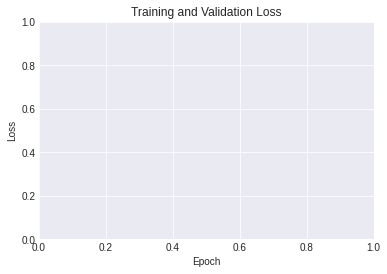

In [21]:
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel('Epoch')

#### Graph the Training & Validation Accuracy

In [ ]:
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy")
plt.xlabel('Epoch')

#### Reporting Testing Loss and Accuracy

In [ ]:
test_loss, test_acc = run_model()
print(f'Loss {test_loss}')
print(f'acc {test_acc}')

## Convolutional layers 

#### Instantiating a Model and Training it
You may want to edit run_model to print out the epochs for this section

In [ ]:
model = Dog_Classifier_Conv(kernel_size=[], stride=[])
model1, loss1, acc1 = run_model()

#### Graphs

In [ ]:
# Don't forget to label the x and y axis
plt.title('CNN Training and Validation Loss')
plt.show()

plt.title('CNN Training and Validation Accuracy')

#### Reporting Testing Loss and Accuracy

In [ ]:
test_loss, test_acc = run_model()
print(f'Loss {test_loss}')
print(f'acc {test_acc}')

## Digging more deeply into convolutional networks

Now try doing this last section on your own, here are some useful keyboard shortcuts while using jupyter

* dd - delete a cell
* a - new cell above
* b - new cell below
* shift + enter - run current cell and move to next cell
* ctrl + enter - run current cell 